In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import backtrader as bt
idx = pd.IndexSlice
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split
from datetime import datetime

In [3]:
nifty_meta = pd.read_csv('data/ind_nifty100list.csv')

In [4]:
tickers = list(nifty_meta[nifty_meta.Industry == 'Financial Services'].Symbol)
print(tickers)

['AXISBANK', 'BAJFINANCE', 'BAJAJFINSV', 'BAJAJHLDNG', 'BANDHANBNK', 'BANKBARODA', 'CHOLAFIN', 'HDFCAMC', 'HDFCBANK', 'HDFCLIFE', 'HDFC', 'ICICIBANK', 'ICICIGI', 'ICICIPRULI', 'INDUSINDBK', 'KOTAKBANK', 'MUTHOOTFIN', 'PAYTM', 'PEL', 'PNB', 'SBICARD', 'SBILIFE', 'SBIN']


In [5]:
prices = pd.read_csv('data/prices.csv', index_col=['ticker','date'])
prices.head(2)

open        high         low       close
ticker   date                                                      
AXISBANK 2010-01-04  198.779999  199.990005  197.619995  140.712021
         2010-01-05  199.600006  204.000000  199.139999  143.647934

In [6]:
minobs = 2520
nobs = prices.groupby(level='ticker').size()
nobs

ticker
AXISBANK      2572
BAJAJFINSV    2571
BAJAJHLDNG    2572
BAJFINANCE    2572
BANDHANBNK     541
BANKBARODA    2572
GICRE          646
HDFC          2572
HDFCAMC        450
HDFCBANK      2572
HDFCLIFE       629
IBULHSGFIN    1691
ICICIBANK     2572
ICICIGI        664
ICICIPRULI     910
INDUSINDBK    2572
KOTAKBANK     2572
L&TFH         2168
NIACL          633
PEL           2572
PFC           2572
PNB           2572
SBILIFE        661
SBIN          2572
SRTRANSFIN    2573
dtype: int64

In [7]:
keep = nobs[nobs > minobs].index
prices = prices.loc[idx[keep,:], :]      #multiindex slicing using idx; keeps all the 'keep' tickers (first level of indes slicing) then keeps all the dates of the kept tickers using ' : ' right after keep (second level slicing), and keeps all the columns using ' : ' again for columns loc
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 38580 entries, ('AXISBANK', '2010-01-04') to ('SRTRANSFIN', '2020-06-15')
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    38579 non-null  float64
 1   high    38579 non-null  float64
 2   low     38579 non-null  float64
 3   close   38579 non-null  float64
dtypes: float64(4)
memory usage: 1.4+ MB


In [8]:
TICKERS = prices.index.get_level_values('ticker').unique()   #final ticker values after filtering for 10+ yrs data
print(TICKERS)

Index(['AXISBANK', 'BAJAJFINSV', 'BAJAJHLDNG', 'BAJFINANCE', 'BANKBARODA',
       'HDFC', 'HDFCBANK', 'ICICIBANK', 'INDUSINDBK', 'KOTAKBANK', 'PEL',
       'PFC', 'PNB', 'SBIN', 'SRTRANSFIN'],
      dtype='object', name='ticker')


In [9]:
close = prices.unstack('ticker')['close']
close = close.dropna()
close.head(2)

ticker,AXISBANK,BAJAJFINSV,BAJAJHLDNG,BAJFINANCE,BANKBARODA,HDFC,HDFCBANK,ICICIBANK,INDUSINDBK,KOTAKBANK,PEL,PFC,PNB,SBIN,SRTRANSFIN
date,,,,,,,,,,,,,,,
2010-01-04,140.712021,347.934143,494.222076,16.031584,51.206989,429.764343,134.245209,85.319977,133.753540,202.426041,252.234650,61.325417,84.943443,95.066895,421.881561
2010-01-05,143.647934,348.708527,498.012665,15.924150,52.686508,431.226868,134.363205,86.130264,133.613098,204.430389,253.638733,62.669540,86.255913,95.102180,424.757904


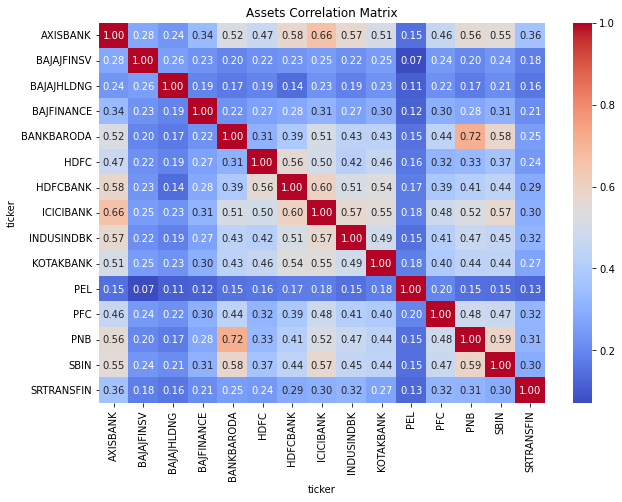

In [10]:
train_close, test_close = train_test_split(close, test_size=0.5, shuffle=False)                   # train test split to train on which are cointegrated pairs from train data and then backtest on test data 
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('images/chart1', dpi=300)


In [11]:
def find_coint_pairs(data):                       #finding cointegrated pairs
    n = data.shape[1]
    p_table = np.ones((n,n))
    pairs = []
    keys = data.keys()
    
    for i in range (n):
        for j in range (i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            p_table[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
                
    return p_table, pairs

[('AXISBANK', 'PEL'), ('AXISBANK', 'SRTRANSFIN'), ('BAJAJFINSV', 'HDFCBANK'), ('BAJAJFINSV', 'INDUSINDBK'), ('BAJAJFINSV', 'KOTAKBANK'), ('BAJAJHLDNG', 'ICICIBANK'), ('BAJAJHLDNG', 'SBIN'), ('BAJFINANCE', 'KOTAKBANK'), ('BANKBARODA', 'ICICIBANK'), ('BANKBARODA', 'SBIN'), ('BANKBARODA', 'SRTRANSFIN'), ('ICICIBANK', 'PEL'), ('ICICIBANK', 'SBIN'), ('INDUSINDBK', 'KOTAKBANK'), ('INDUSINDBK', 'PEL'), ('KOTAKBANK', 'PEL'), ('PEL', 'SBIN')]


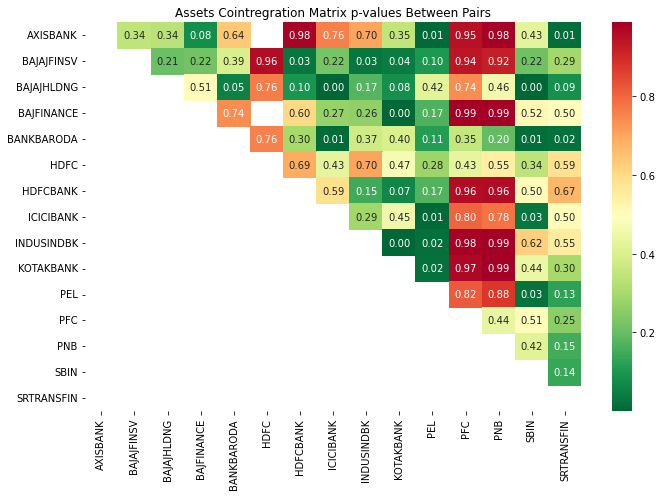

In [12]:
# calculate p-values and plot as a heatmap

pvalues, pairs = find_coint_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('images/chart2', dpi=300)

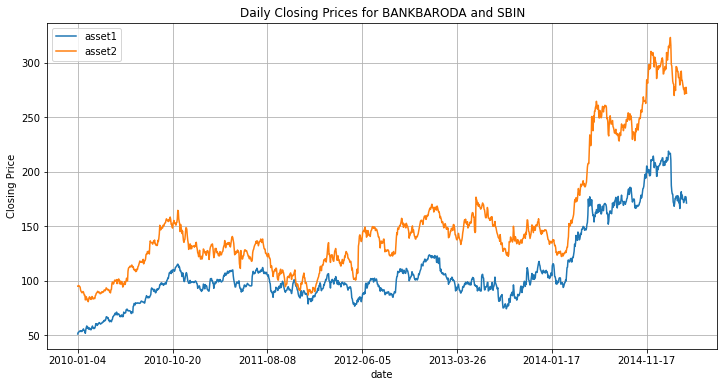

In [13]:
# final pair to test strategy
asset1 = 'BANKBARODA'
asset2 = 'SBIN'

# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
plt.savefig('images/chart3', dpi=300)


In [46]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()
print(model.params)                             #giving slope coefficient

asset1    1.404646
dtype: float64


Hedge Ratio =  1.4046459680586496


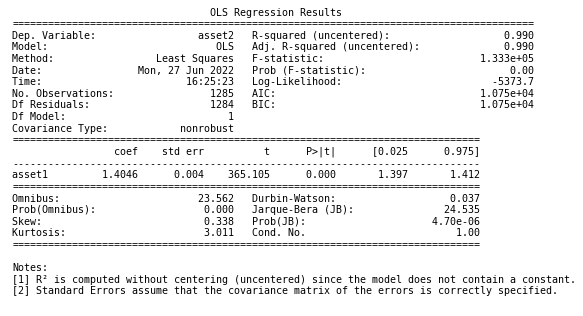

In [47]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('images/chart4', dpi=300);
print('Hedge Ratio = ', model.params[0])

In [48]:
class PandasData(bt.feed.DataBase):
    params = (
        ('datetime', 'date'),
        ('open', 'close'),
        ('high', 'close'),
        ('low', 'close'),
        ('close', 'close'),
        ('volume', None),
        ('openinterest', None)
        )

In [74]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(100000.0)

In [75]:
x = len(close.index)
close_test = close.tail(int(x/2))
close_test['ratio'] = close_test['BANKBARODA']/ close_test['SBIN']
avg = close_test['ratio'].mean()
stddev = close_test['ratio'].std()

<ipython-input-75-8d278042e20c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_test['ratio'] = close_test['BANKBARODA']/ close_test['SBIN']


In [76]:
class TestStrategy(bt.Strategy):
    
    def __init__(self):
        self.ratio = self.datas[0].close/ self.datas[1].close
        self.z_score = (self.ratio - avg)/stddev
        self.position1 = self.broker.getcash()/ max(close_test['BANKBARODA'])
        self.position2 = self.broker.getcash()/ max(close_test['SBIN'])
        
    def next(self):
        if (self.z_score > 1):
            self.sell(data = self.datas[0], size = self.position1)
            self.buy(data = self.datas[1], size = self.position2)
            
        elif (self.z_score < -1):
            self.buy(data = self.datas[0], size = self.position1)
            self.sell(data = self.datas[1], size = self.position2)
        
        

In [77]:
S1 = close_test.filter(['date', 'BANKBARODA'], axis=1)
S1.reset_index(drop = False, inplace = True)
S1['date'] = pd.to_datetime(S1['date'] )
S1.rename(columns = {'BANKBARODA':'close'}, inplace = True)
S2 = close_test.filter(['date', 'SBIN'], axis=1)
S2.reset_index(drop = False, inplace = True)
S2['date'] = pd.to_datetime(S2['date'] )
S2.rename(columns = {'SBIN':'close'}, inplace = True)
data1 = bt.feeds.PandasData(dataname = S1, datetime = 'date', close = 'close', 
        open = 'close', high = 'close', low = 'close', volume = None, openinterest = None)
data2 = bt.feeds.PandasData(dataname = S2, datetime = 'date', close = 'close', 
        open = 'close', high = 'close', low = 'close', volume = None, openinterest = None)
cerebro.adddata(data1)
cerebro.adddata(data2)

In [82]:
cerebro.addstrategy(TestStrategy)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = 'sharpe')
cerebro.addanalyzer(bt.analyzers.Returns, _name = 'returns')
test = cerebro.run(runonce = False)
# cerebro.plot(volume = False)

In [83]:
cerebro.broker.getvalue()

24318593.859780066

In [84]:
test[0].analyzers.sharpe.get_analysis()
test[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 5.49382633015485),
             ('ravg', 0.00427535122969249),
             ('rnorm', 1.9369995819651438),
             ('rnorm100', 193.6999581965144)])